In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

## Modell:
$Ax=y$

In [3]:
A = np.random.random(size = (100, 100))
x = np.random.random(size = (100, ))

In [4]:
y = np.dot(A, x)

$A$ ist invertierbar:

In [5]:
np.linalg.inv(A)

array([[ 0.58611217,  0.22754722,  0.22079958, ..., -0.35934623,
         0.66178901,  0.19085717],
       [-0.86053578,  0.35823913, -0.05086583, ..., -0.28753986,
         0.01246512, -1.48921599],
       [ 0.26764428, -0.13717687, -0.92694754, ...,  0.09591585,
        -1.22390556,  2.1684163 ],
       ...,
       [ 0.66359634, -0.39434052,  0.53305901, ...,  0.12365094,
         0.66198343,  0.04954313],
       [-0.06110287,  0.01871632, -0.28590078, ...,  0.03731371,
        -0.48258655,  0.91014539],
       [-1.43651032,  0.47662975, -0.21419412, ..., -0.01676364,
         0.36827009, -2.7539353 ]])

Verlustfunktion: quadratischer Fehler $\Vert y - \hat{y}\Vert^2$

In [6]:
def squared_error(y_true, y_pred):
    return np.sum((y_true - y_pred)**2)

Ableitung der Verlustfunktion nach den predictions $\hat{y}$ ist für ein $\hat{y}_i$: 

$-2(y_i-\hat{y}_i)$

In [7]:
def grad_loss(y_true, y_pred):
    return (-2) * (y_true - y_pred)

Loss, wenn der Mittelwert aller $y_i$ stets als prediction verwendet wird:

In [8]:
squared_error(y, np.mean(y))

222.12952243689784

## EnKF-Algorithmus, wie ich ihn auch sonst implementiert habe

In [9]:
iterations = 100
particles = 100
randomization = True

In [10]:
h_0 = 2
epsilon = 0.5

In [11]:
# Dictionary, in das die Partikel (Vektoren, Schätzungen für x) geschrieben werden
param_dict = {}
# Dictionary, in das für alle Partikel die predictions für y geschrieben werden
y_pred_dict = {}
# Dictionary, in das für alle Partikel die Ableitungen der Verlustfunktion nach den predictions geschrieben werden
jacobian_dict = {}
# Dictionary, das für alle Partikel die Werte der Verlustfunktion enthält
loss_dict = {}

Initialisierung durch eine Normalverteilung und erste Auswertung:

In [12]:
for i in range(particles):
    param_dict["particle_{}".format(i+1)] = np.random.normal(loc = 0, scale = 1, size = x.shape)
    y_pred_dict["particle_{}".format(i+1)] = np.dot(A, param_dict["particle_{}".format(i+1)])
    jacobian_dict["particle_{}".format(i+1)] = grad_loss(y, y_pred_dict["particle_{}".format(i+1)])
    loss_dict["particle_{}".format(i+1)] = squared_error(y, y_pred_dict["particle_{}".format(i+1)])

Mittelwerte aller Parameter der Partikel für die endgültige Schätzung von x:

In [13]:
param_mean = np.mean(list(param_dict.values()), axis = 0)

Loss für die gemittelten Parameter fortlaufend notieren:

In [14]:
loss_evolution = []
loss_evolution.append(squared_error(y, np.dot(A, param_mean)))

In [15]:
# zum Testen der einzelnen Partikel
loss_evolution_single_dict = {}
for i in range(particles):
    loss_evolution_single_dict["particle_{}".format(i+1)] = [squared_error(y, np.dot(A, param_dict["particle_{}".format(i+1)]))]

### EnKF

In [16]:
for iteration in range(iterations):
    
    # update the predictions, jacobian and loss for the new parameters
    for i in range(particles):
        y_pred_dict["particle_{}".format(i+1)] = np.dot(A, param_dict["particle_{}".format(i+1)])
        jacobian_dict["particle_{}".format(i+1)] = grad_loss(y, y_pred_dict["particle_{}".format(i+1)])
        loss_dict["particle_{}".format(i+1)] = squared_error(y, y_pred_dict["particle_{}".format(i+1)])
    
    # compute the mean of the predictions
    y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
    
    # compute the matrix D elementwise
    d = np.zeros(shape = (particles, particles))
    for k in range(particles):
        y_pred_centered = y_pred_dict["particle_{}".format(str(k+1))] - y_pred_mean
        for j in range(particles):
            d[k][j] = np.dot(y_pred_centered, jacobian_dict["particle_{}".format(str(j+1))])
           
    # compute the scalar h_t
    h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
    # matrix with particle parameters as row vectors
    params_all_ptcls = np.array(list(param_dict.values()))
    
    # compute the matrix with the updates for each particle
    params_all_ptcls = params_all_ptcls - h_t * np.dot(d, params_all_ptcls)
    
    # write the updates back into the dictionary
    for i in range(particles):
        param_dict["particle_{}".format(str(i+1))] = params_all_ptcls[i]
        if randomization:
            # add randomization/ noise to each particle
            stddev = 0.1
            noise = np.random.normal(loc = 0.0,
                                     scale = stddev,
                                     size = param_dict["particle_{}".format(str(i+1))].shape)
            new_param = param_dict["particle_{}".format(str(i+1))] + noise
            param_dict["particle_{}".format(str(i+1))] = new_param
    if randomization:
        # randomize particles around their mean
        param_dict_mean = list(np.mean(list(param_dict.values()), axis = 0))
        for i in range(particles):
            stddev = 0.1
            noise = np.random.normal(loc = 0.0,
                                     scale = stddev,
                                     size = param_dict["particle_{}".format(str(i+1))].shape)
            new_params = param_dict_mean + noise
            param_dict["particle_{}".format(str(i+1))] = new_params
    
    # compute loss for the parameter means
    param_mean = np.mean(params_all_ptcls, axis = 0)
    loss_evolution.append(squared_error(y, np.dot(A, param_mean)))
    
    # zum Testen der einzelnen Partikel
    for i in range(particles):
        loss_evolution_single_dict["particle_{}".format(i+1)].append(squared_error(y, np.dot(A, param_dict["particle_{}".format(i+1)])))

Mit Randomization: Loss steigt ungleichmäßig.

Ohne Randomization: Loss bleibt gleich ?!

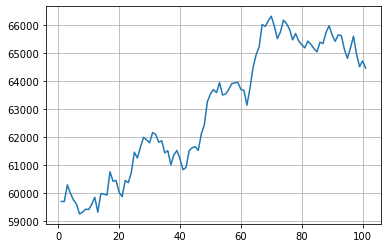

In [17]:
plt.plot(np.arange(len(loss_evolution))+1, loss_evolution)
plt.grid()
plt.show()

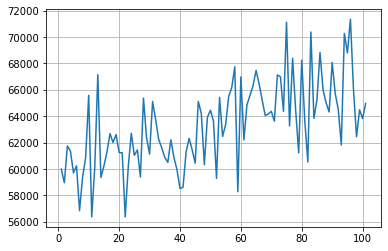

In [18]:
plt.plot(np.arange(len(loss_evolution_single_dict["particle_1"]))+1, loss_evolution_single_dict["particle_1"])
plt.grid()
plt.show()

## EnKF wie für inverse Probleme

Noise macht das Ergebnis kaputt.

In [19]:
noise = False
y = np.dot(A, x)
stddev_noise = np.ones(shape = y.shape)
if noise:
    noises = np.random.normal(loc = 0, scale = stddev_noise, size = y.shape)
    y = y + noises
    gamma = np.diag(stddev_noise**2)

In [20]:
batch = True
if batch:
    epochs = 10
    batch_size = 10         
else:
    epochs = 100
    batch_size = y.shape[0]

In [21]:
n = y.shape[0]
num_batches = int(np.ceil(n / batch_size))
batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
batch_indices[-1] = n

In [22]:
# Dictionary, in das die Partikel (Vektoren, Schätzungen für x) geschrieben werden
param_dict = {}
# Dictionary, in das für alle Partikel die predictions für y geschrieben werden
y_pred_dict = {}
# Dictionary, das für alle Partikel die Werte der Verlustfunktion enthält
loss_dict = {}

In [23]:
for i in range(particles):
    param_dict["particle_{}".format(i+1)] = np.random.normal(loc = 0, scale = 1, size = x.shape)
    y_pred_dict["particle_{}".format(i+1)] = np.dot(A, param_dict["particle_{}".format(i+1)])
    loss_dict["particle_{}".format(i+1)] = squared_error(y, y_pred_dict["particle_{}".format(i+1)])

In [24]:
param_mean = np.mean(list(param_dict.values()), axis = 0)

In [25]:
loss_evolution = []
loss_evolution.append(squared_error(y, np.dot(A, param_mean)))

In [28]:
# zum Testen der einzelnen Partikel
loss_evolution_single_dict = {}
for i in range(particles):
    loss_evolution_single_dict["particle_{}".format(i+1)] = [squared_error(y, np.dot(A, param_dict["particle_{}".format(i+1)]))]

In [29]:
for epoch in range(epochs):

    A_batches = [A[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(num_batches)]
    y_batches = [y[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(num_batches)]
    if noise:
        gamma_batches = [gamma[int(batch_indices[i]):int(batch_indices[i+1]),int(batch_indices[i]):int(batch_indices[i+1])] for i in range(num_batches)]
    
    for b in range(num_batches):

        # update the predictions and the loss for the new parameters
        for i in range(particles):
            y_pred_dict["particle_{}".format(i+1)] = np.dot(A_batches[b], param_dict["particle_{}".format(i+1)])
            loss_dict["particle_{}".format(i+1)] = squared_error(y_batches[b], y_pred_dict["particle_{}".format(i+1)])

        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)

        # compute the matrices C
        param_diff_dict = {}
        pred_diff_param_dict = {}
        pred_diff_w_dict = {}
        c_param_w_dict = {}
        c_w_w_dict = {}

        for i in range(particles):
            param_diff_dict["particle_{}".format(str(i+1))] = param_dict["particle_{}".format(str(i+1))] - param_mean
            pred_diff_param_dict["particle_{}".format(str(i+1))] = y_pred_dict["particle_{}".format(str(i+1))] - y_pred_mean
            pred_diff_w_dict["particle_{}".format(str(i+1))] = y_pred_dict["particle_{}".format(str(i+1))] - y_pred_mean
        for i in range(particles):
            param_diff_dict["particle_{}".format(str(i+1))] = np.transpose(np.tile(param_diff_dict["particle_{}".format(str(i+1))], (pred_diff_param_dict["particle_{}".format(str(i+1))].shape[0], 1)))
            pred_diff_param_dict["particle_{}".format(str(i+1))] = np.tile(pred_diff_param_dict["particle_{}".format(str(i+1))], (param_diff_dict["particle_{}".format(str(i+1))].shape[0], 1))
            pred_diff_w_dict["particle_{}".format(str(i+1))] = np.tile(pred_diff_w_dict["particle_{}".format(str(i+1))], (pred_diff_w_dict["particle_{}".format(str(i+1))].shape[0], 1))
            c_param_w_dict["particle_{}".format(str(i+1))] = param_diff_dict["particle_{}".format(str(i+1))] * pred_diff_param_dict["particle_{}".format(str(i+1))]
            c_w_w_dict["particle_{}".format(str(i+1))] = pred_diff_w_dict["particle_{}".format(str(i+1))] * pred_diff_w_dict["particle_{}".format(str(i+1))]
        c_param_w = np.mean(list(c_param_w_dict.values()), axis = 0)
        c_w_w = np.mean(list(c_w_w_dict.values()), axis = 0)

        # write the updates back into the dictionary
        for i in range(particles):
            if noise:
                param_dict["particle_{}".format(str(i+1))] = param_dict["particle_{}".format(str(i+1))] + np.dot(np.dot(c_param_w, np.linalg.pinv(c_w_w + gamma_batches[b])), y_batches[b] - y_pred_dict["particle_{}".format(str(i+1))])
            else:
                param_dict["particle_{}".format(str(i+1))] = param_dict["particle_{}".format(str(i+1))] + np.dot(np.dot(c_param_w, np.linalg.pinv(c_w_w)), y_batches[b] - y_pred_dict["particle_{}".format(str(i+1))])

        # compute loss for the parameter means
        param_mean = np.mean(list(param_dict.values()), axis = 0)
        loss_evolution.append(squared_error(y_batches[b], np.dot(A_batches[b], param_mean)))

        # zum Testen der einzelnen Partikel
        for i in range(particles):
            loss_evolution_single_dict["particle_{}".format(i+1)].append(squared_error(y_batches[b], np.dot(A_batches[b], param_dict["particle_{}".format(i+1)])))

In [30]:
loss_evolution

[66437.43053385541,
 456.69335107869625,
 360.2685952080888,
 237.28121208467329,
 160.11286907409,
 114.7215357903589,
 106.35372572176058,
 132.0594252497073,
 97.76455481121909,
 74.1762229723786,
 105.95791490623685,
 112.1074060620863,
 112.9039684387865,
 94.07407940513258,
 66.99911832321008,
 45.02652830834251,
 50.574570048328646,
 71.53307134394178,
 51.67176969038931,
 39.28943011938428,
 68.79208141305571,
 81.91167272109114,
 81.0284473831165,
 71.97008497593389,
 48.98412192073203,
 33.05203761232542,
 37.73317090320522,
 56.18535006773363,
 39.214840888738685,
 30.00321775168919,
 55.71900861477684,
 68.35569491968525,
 66.86461785070614,
 62.51986712122809,
 40.83674273626952,
 28.280029835470202,
 32.02490146152113,
 49.2873938599915,
 33.50140730884796,
 26.045270843619832,
 48.994593259053104,
 60.18242093648053,
 58.485684258745785,
 57.18947418483041,
 36.14596030908063,
 25.76082276149767,
 28.829685541309058,
 45.451568602164194,
 30.250216038787574,
 23.96480051

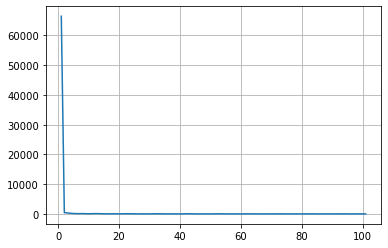

In [31]:
plt.plot(np.arange(len(loss_evolution))+1, loss_evolution)
plt.grid()
plt.show()

Bei Berechnung mit Batches: Oszillationen kommen von den Batches. Für jede Batch ist es aber wieder monoton fallend.

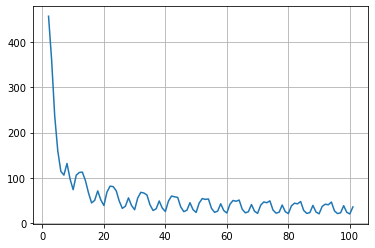

In [32]:
# ohne den initialen Guess
plt.plot(np.arange(len(loss_evolution))[1:]+1, loss_evolution[1:])
plt.grid()
plt.show()

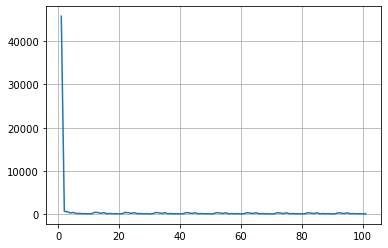

In [33]:
plt.plot(np.arange(len(loss_evolution_single_dict["particle_1"]))+1, loss_evolution_single_dict["particle_1"])
plt.grid()
plt.show()

In [34]:
np.dot(A, param_mean)

array([22.31394014, 24.74891736, 22.70062598, 24.34488892, 26.05333578,
       26.75667863, 20.32420894, 24.32062911, 19.36933589, 22.85516433,
       27.06168025, 26.81031077, 23.90163762, 23.80788018, 24.74949546,
       26.04525672, 23.7697299 , 20.81032386, 25.97834361, 23.25387576,
       25.4654663 , 24.6804228 , 21.30367195, 23.14231284, 21.78751807,
       25.45903964, 22.52710954, 25.81973279, 26.41330096, 28.44554474,
       21.2197023 , 23.18680776, 21.44013556, 24.80552043, 26.39676095,
       24.59390144, 24.31856301, 25.46252963, 25.879486  , 20.20083166,
       26.22648671, 24.95527639, 23.49044873, 23.71875412, 25.35015725,
       25.18658294, 26.09692975, 20.62437022, 21.49408388, 28.66694244,
       21.78540725, 23.48941342, 23.49065639, 25.27004706, 25.45605887,
       23.8749712 , 25.64796221, 24.43006979, 26.05293905, 24.5230663 ,
       23.69834386, 21.52014521, 25.60170014, 23.58096492, 26.72026651,
       25.07153495, 20.68680361, 25.40462703, 25.28785961, 24.06

In [35]:
y

array([24.93864062, 24.09099148, 26.25305628, 24.05640439, 24.64454397,
       28.16979309, 21.67023114, 26.97393195, 22.24643928, 23.35476629,
       27.45352245, 28.53033815, 24.320793  , 27.63236822, 26.14936327,
       24.90531817, 26.07236955, 24.33898551, 26.91819902, 24.20534451,
       25.79499432, 25.88499083, 24.38543291, 25.83176522, 26.83586517,
       24.80273558, 22.71865125, 25.45981492, 26.10706738, 26.89293316,
       24.56265758, 24.8690558 , 23.51943907, 26.20412968, 27.53174095,
       25.37415973, 22.81567239, 25.32572346, 25.50640985, 22.03874206,
       25.24601192, 25.36932264, 24.53813854, 24.3565557 , 25.45253073,
       25.72562487, 26.47877767, 23.9623008 , 23.17563746, 26.54070402,
       23.38731952, 25.96615031, 24.79512153, 25.96092475, 23.95455273,
       24.66617169, 24.75855335, 26.37392893, 24.86833134, 26.45302213,
       26.41893908, 23.37025624, 25.94386236, 25.1289184 , 26.35923403,
       23.85443521, 25.14067224, 26.29386487, 23.66160306, 24.53